In [ ]:

# Install emoji library
!pip install emoji --quiet



In [ ]:
import pandas as pd
import emoji
from sklearn.model_selection import train_test_split

# Load CSV safely
df = pd.read_csv("emoji_tweets.csv", on_bad_lines='skip', engine='python', quoting=3)
df = df.dropna(subset=['Text']).reset_index(drop=True)

# Function to extract emojis
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

# Extract emojis and clean text
df['emoji'] = df['Text'].apply(extract_emojis)
df['text_only'] = df['Text'].apply(lambda x: emoji.replace_emoji(x, replace=''))

# Remove rows with no emojis
df = df[df['emoji'].str.strip() != '']

# Optional: keep only the first emoji
df['emoji'] = df['emoji'].str[0]

# Train-test split
train_df, test_df = train_test_split(df[['text_only', 'emoji']], test_size=0.2, random_state=42)

# Save
train_df.to_csv('train_emoji.csv', index=False)
test_df.to_csv('test_emoji.csv', index=False)

print("Train and test files saved! Rows:", len(train_df), "+", len(test_df))


Train and test files saved! Rows: 467 + 117


In [ ]:
# ✅ 1. Install and Import
!pip install emoji --quiet

import pandas as pd
import numpy as np
import emoji
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer

# ✅ 2. Load and preprocess data
df = pd.read_csv("emoji_tweets.csv", on_bad_lines='skip', engine='python', quoting=3)
df = df.dropna(subset=['Text']).reset_index(drop=True)

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

df['emoji'] = df['Text'].apply(extract_emojis)
df['text_only'] = df['Text'].apply(lambda x: emoji.replace_emoji(x, replace=''))
df = df[df['emoji'].str.strip() != '']
df['emoji'] = df['emoji'].str[0]

# ✅ 3. Group emojis
emoji_groups = {
    'love': ['❤️', '😍', '💙', '😚', '🫦'],
    'hype': ['🔥', '💥', '🚀', '💰'],
    'gesture': ['👉', '👈', '👇', '👂', '🙏', '👌'],
    'emotion': ['😈', '🙃', '😛', '😜', '😉', '😀', '😺', '🐰'],
    'celebrate': ['🏆', '🎉', '🥳', '📱']
}

def map_emoji(e):
    for k, v in emoji_groups.items():
        if e in v:
            return k
    return 'other'

df['label'] = df['emoji'].apply(map_emoji)
df = df[df['label'] != 'other'].reset_index(drop=True)

# ✅ 4. Upsample minority classes
target_size = 200
resampled = []
for label in df['label'].unique():
    group = df[df['label'] == label]
    if len(group) < target_size:
        group = resample(group, replace=True, n_samples=target_size, random_state=42)
    resampled.append(group)
df_bal = pd.concat(resampled).sample(frac=1).reset_index(drop=True)

# ✅ 5. Train-Test Split
train_df, test_df = train_test_split(df_bal[['text_only', 'label']], test_size=0.2, random_state=42, stratify=df_bal['label'])

# ✅ 6. Tokenize and Encode
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text_only'])
maxlen = 50

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text_only']), maxlen=maxlen)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['text_only']), maxlen=maxlen)

le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_test = le.transform(test_df['label'])

num_classes = len(le.classes_)

# ✅ 7. Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super().__init__()
    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        weights = tf.nn.softmax(score, axis=1)
        return tf.reduce_sum(weights * inputs, axis=1)

# ✅ 8. Model Architecture
input_ = Input(shape=(maxlen,))
x = Embedding(input_dim=10000, output_dim=128)(input_)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ 9. Train
model.fit(X_train, y_train, validation_split=0.1, epochs=15, batch_size=32)

# ✅ 10. Evaluate
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.2096 - loss: 1.6073 - val_accuracy: 0.2500 - val_loss: 1.5807
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3055 - loss: 1.5260 - val_accuracy: 0.4167 - val_loss: 1.1811
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.4676 - loss: 1.1654 - val_accuracy: 0.5952 - val_loss: 0.9837
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.6200 - loss: 0.8878 - val_accuracy: 0.7024 - val_loss: 0.6247
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7929 - loss: 0.5469 - val_accuracy: 0.7262 - val_loss: 0.5583
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7926 - loss: 0.4484 - val_accuracy: 0.8214 - val_loss: 0.5518
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7709 - loss: 0.4785 - val_accuracy: 0.7381 - val_loss: 0.5810
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8278 - loss: 0.4068 - val_accuracy: 0.7738 

/tmp/ipython-input-15-408032097.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette='Set2')


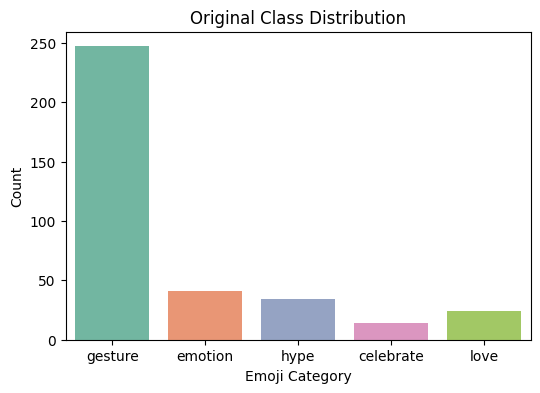

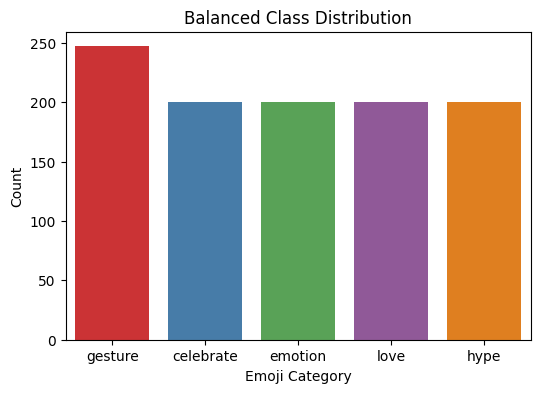

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Original distribution (before upsampling)
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette='Set2')
plt.title("Original Class Distribution")
plt.xlabel("Emoji Category")
plt.ylabel("Count")
plt.show()

# Balanced distribution (after upsampling)
plt.figure(figsize=(6, 4))
sns.countplot(x=df_bal['label'], palette='Set1')
plt.title("Balanced Class Distribution")
plt.xlabel("Emoji Category")
plt.ylabel("Count")
plt.show()


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=15, batch_size=32)


Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8885 - loss: 0.3053 - val_accuracy: 0.8333 - val_loss: 0.3915
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8886 - loss: 0.3087 - val_accuracy: 0.8571 - val_loss: 0.3691
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8859 - loss: 0.2899 - val_accuracy: 0.8929 - val_loss: 0.2750
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8978 - loss: 0.2862 - val_accuracy: 0.8095 - val_loss: 0.3841
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7382 - loss: 0.5535 - val_accuracy: 0.8690 - val_loss: 0.4004
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8641 - loss: 0.3817 - val_accuracy: 0.7976 - val_loss: 0.3843
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8935 - loss: 0.2929 - val_accuracy: 0.8452 - val_loss: 0.3280
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8927 - loss: 0.2480 - val_accuracy: 0.8571 

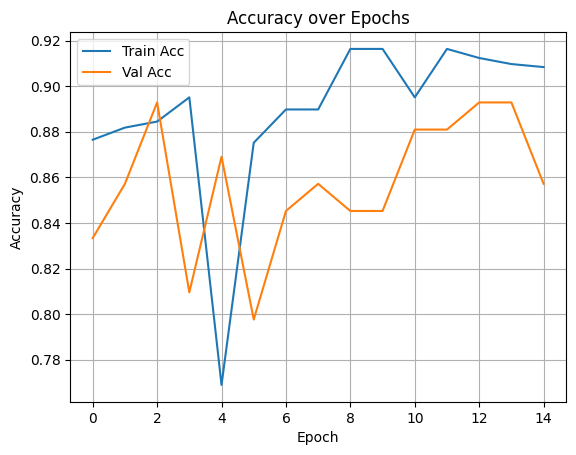

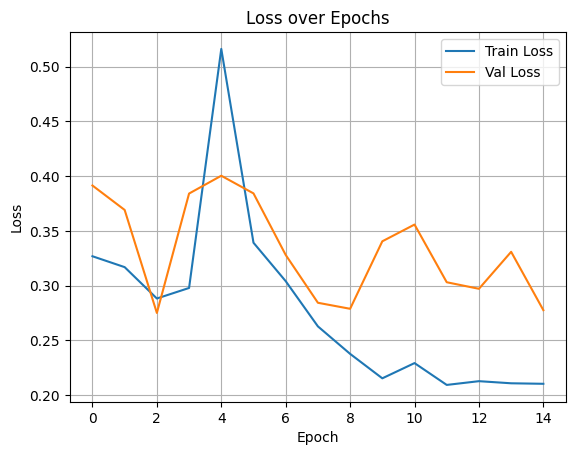

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


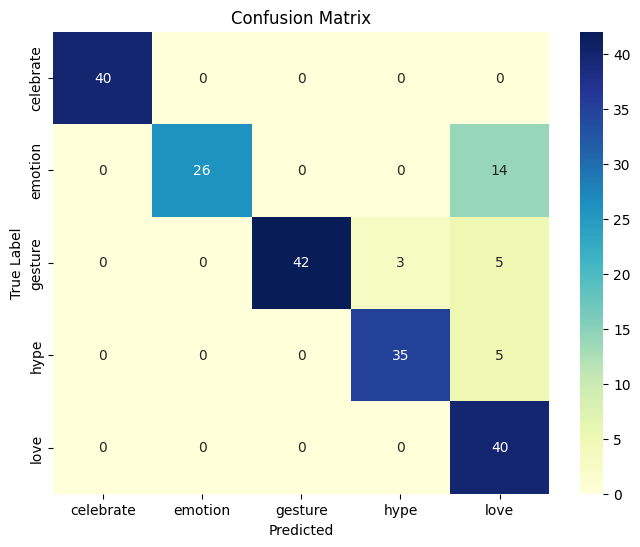

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()
